# Data and Setting

In [1]:
import pandas as pd
from collections import defaultdict
import numpy as np
import random
import networkx as nx
from networkx.algorithms import bipartite
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

### Network

In [2]:
#dataframe for the network 

#names of columns
cols = ['edge_ID','source','target']

#loading Dataframe
df_edges = pd.read_csv('wikigraph_reduced.csv', delimiter = '\t',names = cols).drop(index = 0)

#making edge_ID as int
df_edges['edge_ID'] = list(map(int, df_edges['edge_ID']))

df_edges

nodes=set(df_edges["source"]).union(set(df_edges["target"]))

In [43]:
df_edges

,edge_ID,source,target
1,796,95,1185516
2,909,108,1059989
3,910,108,1062426
4,911,108,1161925
5,1141,134,541222
...,...,...,...
483090,28511768,1791481,1060990
483091,28511769,1791481,1061382
483092,28511771,1791481,1110380
483093,28511772,1791482,80740


In [3]:
#tryng to calculate in-degree from the DataFrame
df_edges.groupby('target').count().mean()

edge_ID    6.401394
source     6.401394
dtype: float64

### Page Names

In [4]:
df_names = pd.read_csv('wiki-topcats-page-names.txt.gz',delimiter = '\t',names =['node name'])

In [5]:
df_names['node'] = [s.split()[0] for s in list(df_names['node name']) ]
df_names['name'] = [' '.join(s.split()[1:]) for s in list(df_names['node name'])]
df_names = df_names.drop('node name',axis = 1)

In [6]:
pages = df_names['node']

In [7]:
df_names

,node,name
0,0,Chiasmal syndrome
1,1,Kleroterion
2,2,Pinakion
3,3,LyndonHochschildSerre spectral sequence
4,4,Zariski's main theorem
...,...,...
1791484,1791484,Noadiah Russell (Yale founder)
1791485,1791485,Cornus officinalis
1791486,1791486,Peter Grummitt
1791487,1791487,Baron Estcourt


### Categories

In [8]:
names = ['cat_name','pages']
df_cat = pd.read_csv('wiki-topcats-categories.txt.gz',sep = ';',names = names)

df_cat['cat_name'] = df_cat.apply(lambda x: x['cat_name'][9:],axis = 1)

df_cat['pages'] = df_cat.apply(lambda x: list(map(int,x['pages'].split())),axis = 1)

df_cat

,cat_name,pages
0,Buprestoidea,"[301, 302, 303, 304, 305, 306, 307, 308, 309, ..."
1,People_from_Worcester,"[1056, 1057, 1058, 1059, 1060, 60971, 76515, 7..."
2,Skin_conditions_resulting_from_physical_factors,"[971, 973, 1166, 1167, 1168, 1169, 1170, 1171,..."
3,Visual_kei_bands,"[1297, 1300, 1311, 1312, 1313, 1314, 1315, 131..."
4,Japanese_rock_music_groups,"[1297, 1300, 1313, 1314, 1315, 1316, 1319, 132..."
...,...,...
17359,British_science_fiction_novels,"[16110, 24545, 39814, 67923, 108629, 108630, 1..."
17360,Television_soundtracks,"[1117, 110192, 110376, 110377, 110380, 110395,..."
17361,Diptera_of_North_America,"[279, 280, 283, 31110, 31129, 31133, 31138, 31..."
17362,Diptera_of_Asia,"[279, 31129, 31133, 31134, 31135, 31136, 31137..."


In [9]:
len(df_cat['cat_name'])

17364

In [10]:
#in order to remove the pages belonging to multiple categories, I made an inverted index key: Page, values: Categories in which the pages appears.
#than I randomly sampled the values in uniform way and built the dataframe again

categories = list(df_cat['cat_name'])
pages_for_cat =list(df_cat['pages'])


d_page_cat = defaultdict(list)
for i,cat in enumerate(categories):
    for pag in pages_for_cat[i]:
        d_page_cat[pag].append(cat)
    



In [11]:
list(d_page_cat.keys())[:10]

[301, 302, 303, 304, 305, 306, 307, 308, 309, 310]

In [12]:
d_random_cat_page = defaultdict(list)

for page in d_page_cat.keys():
    if page in nodes:
        cat_of_page = random.sample(set(d_page_cat[page]),1)
        d_random_cat_page[cat_of_page[0]].append(page)

In [13]:
#some categories has been removed, since there is no pages in it or all the pages are other categories
new_df_cat = pd.DataFrame()
new_df_cat['cat_name'] = d_random_cat_page.keys()
new_df_cat['pages'] = d_random_cat_page.values()
new_df_cat

,cat_name,pages
0,Yeovil_Town_F.C._players,"[76871, 79597, 83893, 83825, 84113, 78741, 807..."
1,Rushden_&_Diamonds_F.C._players,"[79069, 79852, 83145, 84912, 83421, 81010, 805..."
2,Port_Vale_F.C._players,"[79139, 73210, 79612, 74843, 81405, 80937, 777..."
3,People_from_Worcester,"[79143, 541169]"
4,Living_people,"[80237, 679524, 1130402, 1164825, 1164872, 192..."
...,...,...
5272,Irish_rugby_union_players,[1525229]
5273,Communist_Party_of_Great_Britain_members,[1636231]
5274,Nahuatl_words_and_phrases,[1678297]
5275,20th-century_Anglican_bishops,[1780989]


In [14]:
s1 = set(new_df_cat['cat_name'])
s2 = set(df_cat['cat_name'])
s2.difference(s1)

{'School_districts_in_Georgia_(U.S._state)',
 'Non-profit_organizations_based_in_California',
 'Scottish_malt_whisky',
 'United_National_Party_politicians',
 'Universities_and_colleges_in_Ohio',
 'French_botanists',
 'Wollaston_Medal_winners',
 'Populated_places_in_Baranya_county',
 'Musical_groups_from_Minnesota',
 'Catocalinae',
 'Discrimination',
 'Charlotte_Hornets_players',
 'Alumni_of_the_University_of_Hong_Kong',
 'Mountain_ranges_of_the_Great_Basin',
 'Members_of_the_Socialist_Party_of_America',
 'Australian_screenwriters',
 'Urban_adult_contemporary_radio_stations',
 'International_organizations',
 'Australian_songwriters',
 'Utah_Jazz_players',
 'Rare_diseases',
 'Commercial_item_transport_and_distribution',
 'Film_production',
 'Western_Tasmania',
 'Fictional_characters_with_precognition',
 'Portuguese_Roman_Catholics',
 'Flora_of_Vietnam',
 'Multi-sport_events',
 'Villages_in_Ostrw_Wielkopolski_County',
 'Autoimmune_diseases',
 'French_literary_critics',
 'Shoegazing_musica

In [15]:
len(d_page_cat.values())

1791489

In [16]:
inverted_dictionary={}
for i,row in new_df_cat.iterrows():
    for node in row["pages"]:
        inverted_dictionary[node]=row["cat_name"]

# Create Graph

# RQ 1

In [17]:
G=nx.convert_matrix.from_pandas_edgelist(df_edges, 'source', 'target', ['edge_ID'],create_using=nx.DiGraph())


In [18]:
G.add_nodes_from

<bound method DiGraph.add_nodes_from of <networkx.classes.digraph.DiGraph object at 0x7f9863ff2df0>>

In [19]:
nx.is_directed(G)



True

### 1. Is the graph directed?

### How many articles are we considering

In [20]:
len(G.nodes)




98343

### How many Hyperlinks 

In [21]:
len(G.edges)


483094

In [22]:
483094/98343

4.912337431235573

### Avarage Degree

In [23]:
dict_in_degree = dict(G.in_degree())
list_degree_in = list(dict_in_degree.values())
avg_degree_in = np.mean(np.array(list_degree_in))
avg_degree_in



4.912337431235573

In [24]:
dict_out_degree = dict(G.out_degree())
list_degree_out = list(dict_out_degree.values())
avg_degree_out = np.mean(np.array(list_degree_out))
avg_degree_out

4.912337431235573

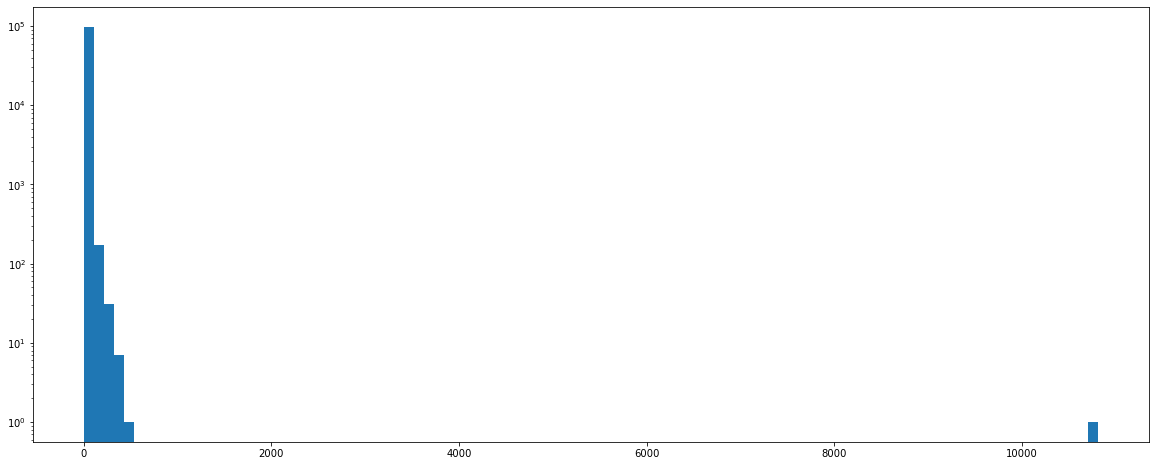

In [25]:
plt.figure(figsize=(20,8))
plt.hist(list_degree_in,log="xy",bins=100);

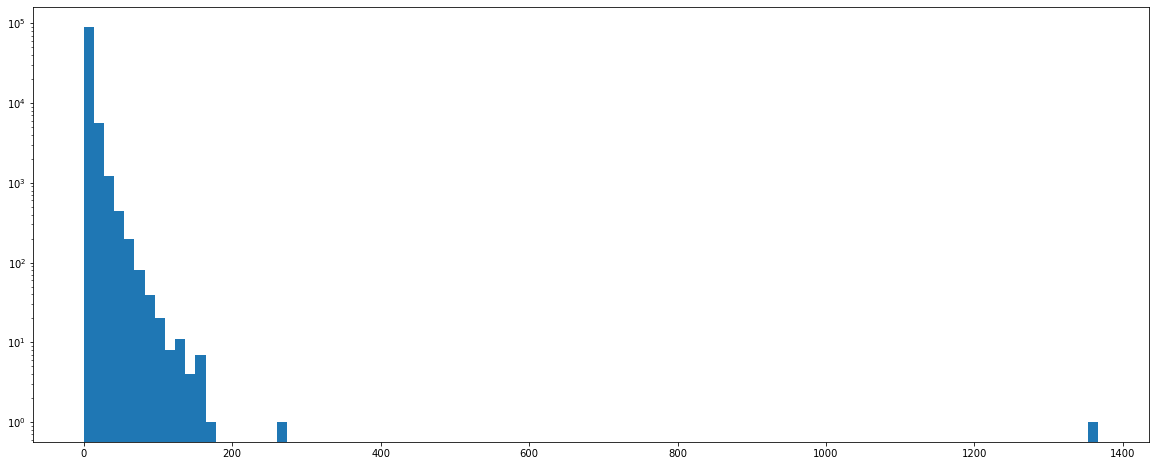

In [26]:
plt.figure(figsize=(20,8))
plt.hist(list_degree_out,log="xy",bins=100);

In [27]:
from collections import deque
def BFS_distances(G,v,inf_distances=True,p=None):
    "we use a standard iterative BFS with a queue to avoid having too many recursive calls"
    inf=float("inf")
    
    q = deque()
    discovered={}
    discovered[v] = 0
    # put starting vertex in the queue
    q.append(v)
    edges_with_distances=[]
    while q:
        v = q.popleft()
        
        edges_with_distances.append((v,discovered[v]))
 
        for u in G.neighbors(v):
            if u not in discovered:
                # mark it discovered and push it into queue
                discovered[u] = discovered[v]+1
                q.append(u)
    return edges_with_distances
    

# RQ2 (DA FINIRE)

In [28]:
BFS_distances(G,95)

[(95, 0),
 (1185516, 1),
 (150451, 2),
 (1062563, 2),
 (1178930, 2),
 (1184017, 2),
 (1184695, 2),
 (1761109, 2),
 (1177884, 3),
 (110209, 3),
 (688300, 3),
 (943780, 3),
 (1057618, 3),
 (1058061, 3),
 (1058123, 3),
 (1058832, 3),
 (1059127, 3),
 (1059279, 3),
 (1059658, 3),
 (1060403, 3),
 (1060445, 3),
 (1060529, 3),
 (1060572, 3),
 (1060926, 3),
 (1060995, 3),
 (1061105, 3),
 (1061808, 3),
 (1061851, 3),
 (1061865, 3),
 (1061882, 3),
 (1061891, 3),
 (1061905, 3),
 (1061966, 3),
 (1062107, 3),
 (1062129, 3),
 (1063050, 3),
 (1063517, 3),
 (1063559, 3),
 (1063850, 3),
 (1063900, 3),
 (1064265, 3),
 (1065404, 3),
 (1066682, 3),
 (1163441, 3),
 (1163564, 3),
 (1163693, 3),
 (1174957, 3),
 (1183891, 3),
 (1184225, 3),
 (1240445, 3),
 (1377543, 3),
 (1377636, 3),
 (1551064, 3),
 (1731279, 3),
 (1731281, 3),
 (358617, 3),
 (689637, 3),
 (689640, 3),
 (1053744, 3),
 (1054633, 3),
 (1055075, 3),
 (1057056, 3),
 (1057316, 3),
 (1057884, 3),
 (1058280, 3),
 (1058318, 3),
 (1058392, 3),
 (10603

# RQ3

In [29]:
nx.set_node_attributes(G, inverted_dictionary, name="Category")

In [30]:
def most_central_article(G,category):
    nodes=list(map(int,d_random_cat_page[category]))
    assert len(nodes)>0,"Empty/non-existent category!"
    max_in_degree=list(G.in_degree(nodes))
    return max(max_in_degree,key=lambda x:x[1])

In [31]:
most_central_article(G,'Debut_albums')

(1227839, 13)

In [32]:
p=[95,108]
C="Debut_albums"

### This algorithm requires an explaination

In [33]:
def graph_exploration(G,p,C):
    most_central=most_central_article(G,C)[0]
    if most_central not in p:
        p.append(most_central)
    
    new_graph=nx.empty_graph(create_using=nx.DiGraph())
    
    for node1 in p:
        for node2 in p:
            if node1!=node2:
                distances=dict(BFS_distances(G,node1))
                if node2 in distances:
                    new_graph.add_edge(node1,node2,weight=distances[node2])
    return new_graph

In [34]:
new_graph=graph_exploration(G,p,C)

In [35]:
new_graph.edges

OutEdgeView([(95, 1227839), (108, 1227839)])

In [36]:
nx.get_edge_attributes(new_graph,"weight")

{(95, 1227839): 9, (108, 1227839): 9}

# RQ5

In [37]:
def BFS_distances(G,v,inf_distances=True,p=None):
    "we use a standard iterative BFS with a queue to avoid having too many recursive calls"
    inf=float("inf")
    
    q = deque()
    discovered={}
    discovered[v] = 0
    # put starting vertex in the queue
    q.append(v)
    edges_with_distances=[]
    vertices=G.nodes
    while q:
        v = q.popleft()
        
        edges_with_distances.append((v,discovered[v]))
 
        for u in G.neighbors(v):
            if u not in discovered:
                # mark it discovered and push it into queue
                discovered[u] = discovered[v]+1
                q.append(u)
    return edges_with_distances
    

In [38]:
from tqdm import tqdm

In [39]:
Category1='Debut_albums'
Category2='American_television_actors'
Category_test='Association_football_goalkeepers'

In [40]:
nodes=list(map(int,d_random_cat_page[Category1]))
all_distances={}
for v in tqdm(nodes):
    distances=BFS_distances(G,v)
    all_distances[v]=dict(distances)

  2%|▏         | 40/1708 [00:04<03:11,  8.69it/s]


KeyboardInterrupt: 

In [ ]:
all_distances[95]

In [ ]:
counter=0
medians=[]

for i in d_random_cat_page:
    counter+=1
    temp_nodes=list(map(int,d_random_cat_page[i]))
    distances=[]
    
    
    for c_0 in nodes:
        for c_i in temp_nodes:
            try:
                distances.append(all_distances[c_0][c_i])
            except KeyError:
                distances.append(float("inf"))
    
    medians.append((i,np.median(np.array(distances))))
    #print("The distance between", Category1, "and", i,"is", np.median(np.array(distances)),"    Counter= ",counter,"/",len(d_random_cat_page))


In [ ]:
medians=sorted(medians,key=lambda x:x[1])

In [ ]:
medians

## RQ 6

Write a function that sorts the categories in the graph according to their PageRank (PR). For this task you need to model the network of categories such that you can apply the PR algorithm.



L'algoritmo completo per il calcolo del PageRank fa ricorso all'uso della teoria dei processi Markov ed è classificato nella vera categoria degli algoritmi di Link Analysis Ranking. Dalla formula inizialmente sviluppata dai fondatori di Google, Sergey Brin e Larry Page, è possibile comprendere come il PageRank viene distribuito tra le pagine:

$PR[A]={\frac  {1-d}{N}}+d\left(\sum _{{k=1}}^{n}{\frac  {PR[P_{k}]}{C[P_{k}]}}\right)$

Dove:

* PR[A] è il valore di PageRank della pagina A che vogliamo calcolare.
* N è il numero totale di pagine note.
* n è il numero di pagine che contengono almeno un link verso A. Pk rappresenta ognuna di tali pagine.
* PR[Pk] sono i valori di PageRank di ogni pagina Pk.
* C[Pk] sono il numero complessivo di link contenuti nella pagina che offre il link.
* d (damping factor) è un fattore deciso da Google e che nella documentazione originale assume valore 0,85. Può essere aggiustato da Google per decidere la percentuale di PageRank che deve transitare da una pagina all'altra e il valore di PageRank minimo attribuito ad ogni pagina in archivio.
Dalla formula si nota quindi che all'aumentare del numero di link complessivi dei siti che puntano ad A il PageRank aumenta.

In [47]:
cat_of_page = {}

for cat in d_random_cat_page:
    for page in d_random_cat_page[cat]:
        cat_of_page[page] = cat 

In [51]:
df_edges

#df_edges_cat = pd.DataFrame()

,edge_ID,source,target
1,796,95,1185516
2,909,108,1059989
3,910,108,1062426
4,911,108,1161925
5,1141,134,541222
...,...,...,...
483090,28511768,1791481,1060990
483091,28511769,1791481,1061382
483092,28511771,1791481,1110380
483093,28511772,1791482,80740


In [53]:
df_edges_cat['source'] = [cat_of_page[page] for page in df_edges['source']]
df_edges_cat['target'] = [cat_of_page[page] for page in df_edges['target']]


In [54]:
df_edges_cat

,source,target
0,Debut_albums,Living_people
1,Debut_albums,English-language_films
2,Debut_albums,Actors_from_Connecticut
3,Debut_albums,American_record_producers
4,English-language_films,UK_MPs_19351945
...,...,...
483089,English-language_films,Jewish_comedians
483090,English-language_films,American_military_personnel_of_World_War_II
483091,English-language_films,Year_of_birth_missing_(living_people)
483092,Blackpool_F.C._players,Bury_F.C._players


In [55]:
G_cat=nx.convert_matrix.from_pandas_edgelist(df_edges_cat, 'source', 'target',create_using=nx.DiGraph())

In [100]:
sorted(list(nx.pagerank(G_cat,alpha = 0.85).items()),key = lambda x: x[0])


[('1._FC_Kaiserslautern_players', 4.593919118984325e-05),
 ('1._FC_Kln_players', 0.00024713915777862573),
 ('1._FC_Nuremberg_players', 0.00013543331841965725),
 ('1._FC_Union_Berlin_players', 3.052353704023755e-05),
 ('1._FSV_Mainz_05_players', 6.877388425814696e-05),
 ('13th-century_Christian_saints', 3.812640803035024e-05),
 ('13th-century_English_people', 5.022834708872648e-05),
 ('13th-century_Roman_Catholic_bishops', 7.235162688912507e-05),
 ('14th-century_English_people', 4.262547609861379e-05),
 ('15th-century_English_people', 0.00010322752243234141),
 ('15th-century_Italian_people', 3.052353704023755e-05),
 ('15th-century_Roman_Catholic_bishops', 7.549167410723763e-05),
 ('16th-century_English_people', 0.000319879566951377),
 ('16th-century_Irish_people', 6.679847226005416e-05),
 ('16th-century_Protestants', 5.950208692846601e-05),
 ('16th-century_Roman_Catholics', 7.737360236952803e-05),
 ('16th-century_venerated_Christians', 6.977073137941534e-05),
 ('16th-century_women', 5.0

In [101]:
def PageRank(G,alpha=0.85,max_iter=99):
    PR = defaultdict(lambda : 1/len(G.nodes()))
    for i in range(max_iter):
        for page in G.nodes():
            PR[page] = ((1-alpha)/len(G.nodes())) + (alpha)*(sum(PR[pointer]/len(list(G.successors(pointer))) for pointer in G.predecessors(page)))
    return PR
    

In [102]:
sorted(list(PageRank(G_cat).items()),key = lambda x: x[0])

[('1._FC_Kaiserslautern_players', 4.2354160918784165e-05),
 ('1._FC_Kln_players', 0.00022253191881731958),
 ('1._FC_Nuremberg_players', 0.0001234299307925163),
 ('1._FC_Union_Berlin_players', 2.842524161455373e-05),
 ('1._FSV_Mainz_05_players', 6.341387592425549e-05),
 ('13th-century_Christian_saints', 3.534161584144864e-05),
 ('13th-century_English_people', 4.6545440241860296e-05),
 ('13th-century_Roman_Catholic_bishops', 6.56120419155391e-05),
 ('14th-century_English_people', 3.962906601496539e-05),
 ('15th-century_English_people', 9.315549309404198e-05),
 ('15th-century_Italian_people', 2.842524161455373e-05),
 ('15th-century_Roman_Catholic_bishops', 6.801632617952158e-05),
 ('16th-century_English_people', 0.0002913051959304992),
 ('16th-century_Irish_people', 6.146367972425853e-05),
 ('16th-century_Protestants', 5.424701560487222e-05),
 ('16th-century_Roman_Catholics', 6.964900741034489e-05),
 ('16th-century_venerated_Christians', 6.273263318344998e-05),
 ('16th-century_women', 4.6